# OCC daily EDA

EDA de dataset por día

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

date_str = "20231206"

base_dir = f"harvester/occ/{date_str}/"
df = spark.read.json(f"{base_dir}/occ-{date_str}.jsonl.gz")
categories = spark.read.json(f"{base_dir}/occ-{date_str}-categories.json")
subcategories = spark.read.json(f"{base_dir}/occ-{date_str}-subcategories.json")

In [3]:
df.printSchema()

root
 |-- Job:value: string (nullable = true)
 |-- __typename: string (nullable = true)
 |-- applied: boolean (nullable = true)
 |-- autoinclusion: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- autoinclusion: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |-- bullets: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- __ref: string (nullable = true)
 |-- category: struct (nullable = true)
 |    |-- __ref: string (nullable = true)
 |-- company: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- confidential: boolean (nullable = true)
 |    |-- logoUrl: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- namePretty: string (nullable = true)
 |    |-- profile: struct (nullable = true)
 |    |    |-- __ref: string (nullable = true)
 |    |-- rel: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- contact: struct (nullable =

In [4]:
df.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Número de Registros

In [5]:
dfu = df.dropDuplicates(["id"])
#dfu = df.dropDuplicates(["id"]).filter(df.redirect.type < 2)
record_count = dfu.count()
print(f"Registros totales: {df.count()}, id unicos: {record_count}")

Registros totales: 127010, id unicos: 122738


### Por tipo de redireccionamiento

- 0: No redireccionadas
- 1: ? (¿redireccionamiento pagado?)
- 2: Redir fuera del sitio (¿son agregadas?)

In [6]:
dfu.groupby("redirect.type").count().show()

+----+-----+
|type|count|
+----+-----+
|   0|69649|
|   1| 4000|
|   2|49089|
+----+-----+



### Por tipo de anuncio
Tablas para todas las vacantes y paras las únicas. 

Notar que las Premium parecen tener mas duplicadas, puede ser por el proceso de scraping cuando aparecen en varios SERP

In [7]:
df.groupby("jobType").count().show()

+--------+-----+
| jobType|count|
+--------+-----+
| PREMIUM| 4891|
|STANDOUT|22861|
| CLASSIC|99258|
+--------+-----+



In [8]:
dfu.groupby("jobType").count().show()

+--------+-----+
| jobType|count|
+--------+-----+
| PREMIUM| 3492|
|STANDOUT|22686|
| CLASSIC|96560|
+--------+-----+



### Tipo de Anuncio / redireccionamiento

CLASSIC / Redir=2 => Suponemos que son las agregadas

In [9]:
dfu.groupby("jobType").pivot("redirect.type").count().show()

+--------+-----+----+-----+
| jobType|    0|   1|    2|
+--------+-----+----+-----+
| PREMIUM| 3464|  28| null|
|STANDOUT|22420| 186|   80|
| CLASSIC|43765|3786|49009|
+--------+-----+----+-----+



#### Proporciones por JobType

In [10]:
pdf = dfu.groupby("jobType").pivot("redirect.type").count().toPandas().fillna(0).set_index('jobType')
#pdf.columns = ['NoRedir', 'Redir1', 'Redir2']
pdf.div(pdf.sum(axis=1), axis=0)

,0,1,2
jobType,,,
PREMIUM,0.991982,0.008018,0.000000
STANDOUT,0.988275,0.008199,0.003526
CLASSIC,0.453242,0.039209,0.507550


#### Proporciones por tipo de redir

Esto demostraría que las Redir2 son agregadas no pagadas ya que practicamente todas son clásicas

In [11]:
pdf.div(pdf.sum(axis=0), axis=1)

,0,1,2
jobType,,,
PREMIUM,0.049735,0.0070,0.00000
STANDOUT,0.321900,0.0465,0.00163
CLASSIC,0.628365,0.9465,0.99837


#### Proporciones del total

In [12]:
pdf.div(pdf.sum().sum())

,0,1,2
jobType,,,
PREMIUM,0.028223,0.000228,0.000000
STANDOUT,0.182666,0.001515,0.000652
CLASSIC,0.356573,0.030846,0.399298


## Categorias

### Totales

In [13]:
cat_count = dfu.groupby("category").count().orderBy(F.col("count").desc())
split_col = F.split(cat_count["category.__ref"].cast("String"), ":")
cat_count = cat_count.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count = cat_count.join(categories.select("id", "description"), cat_count.category_id == categories.id, how="inner")
cat_count = cat_count.select(["category_id", "description", "count"]).orderBy(F.col("count").desc())

In [14]:
cat_count = cat_count.withColumn("pct", F.col("count") / record_count)
cat_count.show(cat_count.count(), truncate=False)

+-----------+------------------------------------------------+-----+---------------------+
|category_id|description                                     |count|pct                  |
+-----------+------------------------------------------------+-----+---------------------+
|19         |Ventas                                          |24073|0.1961332268735029   |
|1          |Administrativo                                  |15878|0.12936498883801267  |
|17         |Tecnologías de la Información - Sistemas        |14459|0.11780377715133047  |
|10         |Logística - Transporte - Distribución - Almacén |11031|0.08987436653685085  |
|4          |Contabilidad - Finanzas                         |10842|0.08833450113249361  |
|11         |Manufactura - Producción - Operación            |8963 |0.07302546888494191  |
|21         |Atención a clientes - Call Center               |7961 |0.06486173801104793  |
|9          |Ingeniería                                      |7113 |0.05795271228144503  |

### Proporciones por tipo de Redir

In [16]:
split_col = F.split(dfu["category.__ref"].cast("String"), ":")
cat_count_redir = dfu.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count_redir = cat_count_redir.groupby("category_id").pivot("redirect.type").count()
cat_count_redir = cat_count_redir.join(categories.select("id", "description"), cat_count_redir.category_id == categories.id, how="inner")
cat_count_redir = cat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
cat_count_redir.columns = ["Category", "NoRedir", "Redir1", "Redir2"]
cat_count_redir = cat_count_redir.set_index("Category")
cat_count_redir = cat_count_redir.div(cat_count_redir.sum(axis=1), axis=0)
cat_count_redir

,NoRedir,Redir1,Redir2
Category,,,
Ventas,0.604827,0.028538,0.366635
Contabilidad - Finanzas,0.710939,0.026102,0.262959
Tecnologías de la Información - Sistemas,0.479010,0.079604,0.441386
Logística - Transporte - Distribución - Almacén,0.568761,0.014595,0.416644
Administrativo,0.373347,0.019335,0.607318
Manufactura - Producción - Operación,0.555060,0.019413,0.425527
Ingeniería,0.610572,0.019401,0.370027
Atención a clientes - Call Center,0.497048,0.020600,0.482351
Recursos humanos,0.704080,0.044855,0.251066


#### Categorías en las que OCC es débil

Mayor proporción de agregadas

In [17]:
cat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
Category,,,
,0.000000,0.000000,1.000000
Administrativo,0.373347,0.019335,0.607318
Atención a clientes - Call Center,0.497048,0.020600,0.482351
Servicios generales - Oficios - Seguridad,0.456997,0.075073,0.467930
Turismo - Hospitalidad - Gastronomía,0.512525,0.023547,0.463928
Deportes - Salud - Belleza,0.537975,0.018987,0.443038
Tecnologías de la Información - Sistemas,0.479010,0.079604,0.441386
Manufactura - Producción - Operación,0.555060,0.019413,0.425527
Educación,0.554629,0.025021,0.420350


## Subcategorías

In [18]:
subcat_count = dfu.groupby("subcategory").count().orderBy(F.col("count").desc())
split_col = F.split(subcat_count["subcategory.__ref"].cast("String"), ":")
subcat_count = subcat_count.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count = subcat_count.join(subcategories.select("id", "description"), subcat_count.subcategory_id == subcategories.id, how="inner")
subcat_count.orderBy(F.col("count").desc()).show(25, truncate=False)

+--------------------+-----+--------------+---+-------------------------------------+
|subcategory         |count|subcategory_id|id |description                          |
+--------------------+-----+--------------+---+-------------------------------------+
|{JobSubcategory:29} |9881 |29            |29 |Administración                       |
|{JobSubcategory:260}|6424 |260           |260|Atención al cliente                  |
|{JobSubcategory:319}|5376 |319           |319|Ventas en general                    |
|{JobSubcategory:242}|4080 |242           |242|Desarrollo de software - Programador |
|{JobSubcategory:149}|3834 |149           |149|Almacén - Inventario                 |
|{JobSubcategory:275}|2730 |275           |275|Administración de ventas             |
|{JobSubcategory:78} |2721 |78            |78 |Contabilidad                         |
|{JobSubcategory:286}|2236 |286           |286|Ventas de campo                      |
|{JobSubcategory:190}|1909 |190           |190|Recluta

In [19]:
split_col = F.split(dfu["subcategory.__ref"].cast("String"), ":")
subcat_count_redir = dfu.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count_redir = subcat_count_redir.groupby("subcategory_id").pivot("redirect.type").count()
subcat_count_redir = subcat_count_redir.join(subcategories.select("id", "description"), subcat_count_redir.subcategory_id == subcategories.id, how="inner")
subcat_count_redir = subcat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
subcat_count_redir.columns = ["subcategory", "NoRedir", "Redir1", "Redir2"]
subcat_count_redir = subcat_count_redir.set_index("subcategory")
subcat_count_redir = subcat_count_redir.div(subcat_count_redir.sum(axis=1), axis=0)
pd.set_option('display.max_rows', None)
subcat_count_redir

,NoRedir,Redir1,Redir2
subcategory,,,
Ventas en general,0.561198,0.029762,0.409040
Atención al cliente,0.393057,0.021171,0.585772
Contabilidad,0.772878,0.013965,0.213157
Ventas de campo,0.791145,0.029517,0.179338
Almacén - Inventario,0.448357,0.014345,0.537298
Administración,0.170529,0.016395,0.813076
Administración de ventas,0.535531,0.028938,0.435531
Reclutamiento y selección de personal,0.762703,0.042431,0.194866
Desarrollo de software - Programador,0.356373,0.176471,0.467157


In [20]:
subcat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
subcategory,,,
,0.000000,0.000000,1.000000
Historia,0.000000,0.000000,1.000000
Ilustración,0.000000,0.000000,1.000000
Mesero,0.011494,0.011494,0.977011
Taquillero,0.061224,0.000000,0.938776
Lavandería,0.071429,0.000000,0.928571
Biotecnología,0.117647,0.000000,0.882353
Camarista,0.136842,0.000000,0.863158
Administración,0.170529,0.016395,0.813076


## Google For Jobs

- Primer campo: si la oferta está disponible para G4J
- Segundo campo: (¿?) si la oferta ya está indexada por G4J

In [21]:
dfu.groupby("googleForJobs").count().sort(F.col("count").desc()).show(truncate=False)

+-----------------------------+------+
|googleForJobs                |count |
+-----------------------------+------+
|{GoogleForJobs, true, true}  |120871|
|{GoogleForJobs, false, false}|1867  |
+-----------------------------+------+



## Ubicación

### Estados

#### Distribución de vacantes por estado con suma acumulada

In [22]:
dfu_loc = dfu.select("id", F.explode("location.locations").alias("loc_data"))
state_count = dfu_loc.groupby("loc_data.state.description").count().sort(F.col("count").desc())
state_count_p = state_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
state_count_p = state_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
state_count_p.show(33)

+-------------------+-----+--------------------+-------------------+
|        description|count|                perc|             cumsum|
+-------------------+-----+--------------------+-------------------+
|   Ciudad de México|35102|    0.28599129853835|   0.28599129853835|
|         Nuevo León|15763|  0.1284280336977953|0.41441933223614524|
|            Jalisco|11648|  0.0949013345500171| 0.5093206667861624|
|   Estado de México|11268| 0.09180530886929883| 0.6011259756554612|
|                   | 6286| 0.05121478270788183|  0.652340758363343|
|          Querétaro| 5500| 0.04481089801039613| 0.6971516563737392|
|    Baja California| 3530|0.028760449086672423| 0.7259121054604116|
|          Chihuahua| 3429|0.027937558050481513| 0.7538496635108931|
|         Guanajuato| 3187|0.025965878538024085| 0.7798155420489172|
|           Veracruz| 2599|0.021175186168912643| 0.8009907282178299|
|             Puebla| 2478| 0.02018934641268393| 0.8211800746305138|
|           Coahuila| 2155| 0.0175

#### Vacantes por estado divididas por tipo Redir, con histograma para Redir2

In [23]:
state_count = dfu.withColumn("loc_data", F.explode("location.locations"))\
                .groupby("loc_data.state.description")\
                .pivot("redirect.type").count()\
                .withColumn("total", F.col("0") + F.col("1") + F.col("2"))\
                .withColumn("NoRedirPct", F.col("0") / F.col("total"))\
                .withColumn("Redir1Pct", F.col("1") / F.col("total"))\
                .withColumn("Redir2Pct", F.col("2") / F.col("total"))\
                .sort(F.col("total").desc())

In [24]:
state_count.show()

+----------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|     description|    0|   1|    2|total|         NoRedirPct|           Redir1Pct|          Redir2Pct|
+----------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|Ciudad de México|19832|1275|13995|35102|  0.564982052304712| 0.03632271665432169| 0.3986952310409663|
|      Nuevo León|11134| 465| 4164|15763| 0.7063376260864048|0.029499460762545202|0.26416291315104995|
|         Jalisco| 6305| 575| 4768|11648| 0.5412946428571429|  0.0493646978021978|0.40934065934065933|
|Estado de México| 7736| 237| 3295|11268| 0.6865459708910188|0.021033013844515443|0.29242101526446573|
|                |  718| 300| 5268| 6286|0.11422208081450844|0.047725103404390706| 0.8380528157811009|
|       Querétaro| 3244| 169| 2087| 5500| 0.5898181818181818|0.030727272727272728|0.37945454545454543|
| Baja California| 1658|  90| 1782| 3530| 0.4696883852691218|0.0254957507

count    33.000000
mean      0.417112
std       0.115223
min       0.225260
25%       0.358354
50%       0.398695
75%       0.469525
max       0.838053
Name: Redir2Pct, dtype: float64


<Axes: >

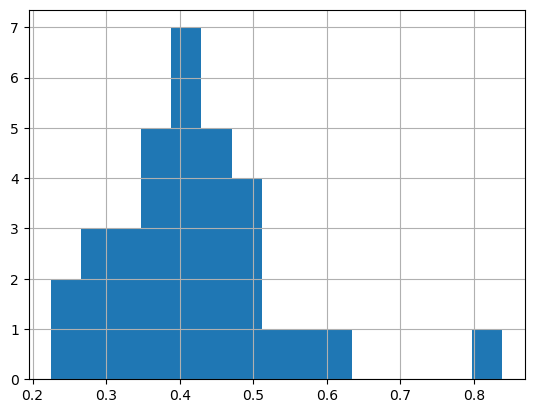

In [25]:
state_count_pd = state_count.toPandas()
print(state_count_pd["Redir2Pct"].describe())
state_count_pd["Redir2Pct"].hist(bins=15)

#### Descripción (granular)

In [26]:
loc_count = dfu.groupby("location.description").count().sort(F.col("count").desc())
loc_count_p = loc_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
loc_count_p = loc_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
print(f"Número de location.description: {loc_count_p.count()}")
loc_count_p.show(30, truncate=False)

Número de location.description: 744
+---------------------------------------+-----+--------------------+-------------------+
|description                            |count|perc                |cumsum             |
+---------------------------------------+-----+--------------------+-------------------+
|Ciudad de México                       |21492|0.17510469455262428 |0.17510469455262428|
|                                       |6245 |0.05088073783180433 |0.22598543238442861|
|Monterrey, Nuevo León                  |5489 |0.044721276214375334|0.27070670859880397|
|Jalisco                                |4932 |0.04018315436132249 |0.31088986296012644|
|Nuevo León                             |4613 |0.03758412227671951 |0.348473985236846  |
|Estado de México                       |3707 |0.03020254525900699 |0.378676530495853  |
|Guadalajara, Jalisco                   |3650 |0.02973814140689925 |0.4084146719027522 |
|Miguel Hidalgo, Ciudad de México       |3355 |0.027334647786341638|0.4357

<Axes: >

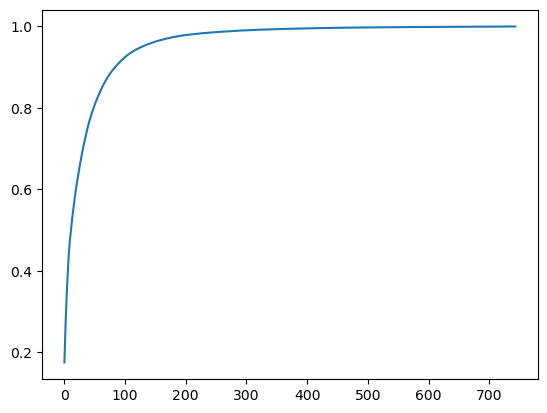

In [27]:
loc_count_p.toPandas()["cumsum"].plot()

## Compañias

Basadas en la url. 

NULL ==> Confidenciales

In [28]:
company_count = dfu.groupby("company.url").count().sort(F.col("count").desc())
print(f"Número de URLs de compañias: {company_count.count()}")
company_count.show(25, truncate=False)

Número de URLs de compañias: 13192
+--------------------------------------------------------------+-----+
|url                                                           |count|
+--------------------------------------------------------------+-----+
|null                                                          |17220|
|empleos/bolsa-de-trabajo-GrabJobs/                            |4244 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                     |2972 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/                 |2791 |
|empleos/bolsa-de-trabajo-truper/                              |1617 |
|empleos/bolsa-de-trabajo-autozone/                            |1601 |
|empleos/bolsa-de-trabajo-Grupo-Salinas/                       |1573 |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/              |1201 |
|empleos/bolsa-de-trabajo-BAIRESDEV-LLC----Tax-ID-99-0381648--/|1036 |
|empleos/bolsa-de-trabajo-gepp/                                |925  |
|empleos/bolsa-de-trabajo-Adecco/         

#### Proporción de vacantes por cia y suma acumulada

In [29]:
ccp = company_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+----------------------------------------------------------------------+-----+---------------------+-------------------+
|url                                                                   |count|perc                 |cumsum             |
+----------------------------------------------------------------------+-----+---------------------+-------------------+
|null                                                                  |17220|0.14029884795254932  |0.14029884795254932|
|empleos/bolsa-de-trabajo-GrabJobs/                                    |4244 |0.03457771839202203  |0.17487656634457135|
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                             |2972 |0.02421417979761769  |0.19909074614218905|
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/                         |2791 |0.022739493881275562 |0.2218302400234646 |
|empleos/bolsa-de-trabajo-truper/                                      |1617 |0.013174404015056462 |0.23500464403852106|
|empleos/bolsa-de-trabajo-autozo

### Excluyendo confidenciales

In [30]:
ccp_noconf = company_count.where("url is not null")
nconf_records = ccp_noconf.agg(F.sum("count")).collect()[0][0]
ccp_noconf = ccp_noconf.withColumn("perc", F.col("count") / nconf_records).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp_noconf.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+----------------------------------------------------------------------+-----+---------------------+-------------------+
|url                                                                   |count|perc                 |cumsum             |
+----------------------------------------------------------------------+-----+---------------------+-------------------+
|empleos/bolsa-de-trabajo-GrabJobs/                                    |4244 |0.04022062586478137  |0.04022062586478137|
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                             |2972 |0.028165810572603728 |0.0683864364373851 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/                         |2791 |0.026450463428040714 |0.09483689986542582|
|empleos/bolsa-de-trabajo-truper/                                      |1617 |0.015324399628499403 |0.11016129949392522|
|empleos/bolsa-de-trabajo-autozone/                                    |1601 |0.015172766731742452 |0.12533406622566767|
|empleos/bolsa-de-trabajo-Grupo-

### Confidenciales

La URL null son confidenciales

In [31]:
dfu.select(["company.url", "company.name"]).where("company.confidential=TRUE").count()

17214

In [32]:
dfu.select("company.url").where("company.confidential=TRUE").distinct().count()

1

### URLs con minusculas -> agregadas

Al parecer las vacantes que tienen company.url en minusculas pero igual a otra URL son de vacantes agregadas

In [33]:
dfu.where("company.url='empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/'").count()

1201

In [34]:
company_count = dfu.where("redirect.type != 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+-----------------------------------------------------------------------+-----+
|url                                                                    |count|
+-----------------------------------------------------------------------+-----+
|null                                                                   |17041|
|empleos/bolsa-de-trabajo-Grupo-Salinas/                                |1573 |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/                       |1201 |
|empleos/bolsa-de-trabajo-BAIRESDEV-LLC----Tax-ID-99-0381648--/         |1036 |
|empleos/bolsa-de-trabajo-Adecco/                                       |922  |
|empleos/bolsa-de-trabajo-Banamex/                                      |463  |
|empleos/bolsa-de-trabajo-Teleperformance/                              |439  |
|empleos/bolsa-de-trabajo-Banorte/                                      |418  |
|empleos/bolsa-de-trabajo-Santander/                                    |372  |
|empleos/bolsa-de-trabajo-Profuturo/    

In [35]:
company_count = dfu.where("redirect.type == 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+---------------------------------------------------------+-----+
|url                                                      |count|
+---------------------------------------------------------+-----+
|empleos/bolsa-de-trabajo-GrabJobs/                       |4244 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |2972 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2791 |
|empleos/bolsa-de-trabajo-truper/                         |1617 |
|empleos/bolsa-de-trabajo-autozone/                       |1601 |
|empleos/bolsa-de-trabajo-gepp/                           |925  |
|empleos/bolsa-de-trabajo-Empleos-TI/                     |739  |
|empleos/bolsa-de-trabajo-marriott-international/         |593  |
|empleos/bolsa-de-trabajo-citigroup-inc-/                 |470  |
|empleos/bolsa-de-trabajo-Workable-ATS/                   |346  |
|empleos/bolsa-de-trabajo-tecnologico-de-monterrey/       |327  |
|empleos/bolsa-de-trabajo-CitiGroup/                      |310  |
|empleos/b

Hay que revisar qué nos dicen estos datos para inferir mejor 

In [36]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == TRUE").count()

49092

In [37]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == FALSE").count()

2549

In [38]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == TRUE").count()

0

In [39]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == FALSE").count()

71097

In [40]:
dfu.where("redirect.isRedirected == TRUE")\
    .where("autoinclusion.autoinclusion == TRUE")\
    .select(["scraped_url", "redirect.externalUrl"])\
    .show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|scraped_url                                                                                                             |externalUrl                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|https://www.occ.com.mx/empleo/oferta/15956790-mx-specialist-full-time-part-time-and-part-time-temporary/                |https://jobs.apple.com/en-us/details/114438297/mx-spe

## Salarios

In [41]:
dfu.select(["salary.from", "salary.to"]).summary().show()

+-------+------------------+------------------+
|summary|              from|                to|
+-------+------------------+------------------+
|  count|            122738|            122738|
|   mean|  7143.91151884502| 8216.253540060943|
| stddev|12282.497184126254|14095.709188928595|
|    min|                 0|                 0|
|    25%|                 0|                 0|
|    50%|                 0|                 0|
|    75%|             11200|             13000|
|    max|            546000|            546000|
+-------+------------------+------------------+



Casi todas las Redir2 (agregadas) no tienen salario, vs 1/3 de las pagadas:

In [42]:
dfu.withColumn("has_salary", F.col("salary.from") != 0).groupby("redirect.type").pivot("has_salary").count().show()

+----+-----+-----+
|type|false| true|
+----+-----+-----+
|   0|23023|46626|
|   1| 2680| 1320|
|   2|45391| 3698|
+----+-----+-----+



Al parecer si alguno de los dos campos de salario es mayor a 0, el otro también lo es

In [43]:
salary = dfu.select(["salary.from", "salary.to"]).where("salary.from > 0 or salary.to > 0")
salary = salary.withColumn("avg", (F.col("from") + F.col("to")) / 2)
salary.summary().show()

+-------+-----------------+------------------+-----------------+
|summary|             from|                to|              avg|
+-------+-----------------+------------------+-----------------+
|  count|            51644|             51644|            51644|
|   mean|16978.34040740454| 19526.88651150182|18252.61345945318|
| stddev|13840.67549518999|15853.934461549807| 14796.9716391965|
|    min|                1|                 2|              1.5|
|    25%|             9000|             10000|           9600.0|
|    50%|            13000|             15000|          14000.0|
|    75%|            20000|             23000|          21000.0|
|    max|           546000|            546000|         546000.0|
+-------+-----------------+------------------+-----------------+



In [44]:
#seleccionar rangos para eliminar outliers - los percentiles son ajustados a algo que permita comparar con CT
outlier_limits = salary.select(F.percentile_approx("avg", [0.009, 0.9995]))
outlier_min, outlier_max = outlier_limits.collect()[0][0]
outlier_limits.show()

+---------------------------------------------------+
|percentile_approx(avg, array(0.009, 0.9995), 10000)|
+---------------------------------------------------+
|                                 [4000.0, 145000.0]|
+---------------------------------------------------+



In [45]:
salary = salary.where(f"avg >= {outlier_min} and avg <= {outlier_max}")
salary.summary().show()

+-------+------------------+------------------+------------------+
|summary|              from|                to|               avg|
+-------+------------------+------------------+------------------+
|  count|             51241|             51241|             51241|
|   mean|16988.769871782362|19542.744540504675|18265.757206143517|
| stddev|13086.038405572306|15054.649255408132|14020.420626955904|
|    min|                33|              4000|            4000.0|
|    25%|              9000|             10000|            9750.0|
|    50%|             13000|             15000|           14000.0|
|    75%|             20000|             23000|           21000.0|
|    max|            140000|            150000|          145000.0|
+-------+------------------+------------------+------------------+



Esto es solo para extraer jobids que va a ser usados despues

In [46]:
with open("occ_jobids_1.txt", "w") as fo:
    [fo.write(f"{y}\n") for y in dfu.select("id").sort(F.col("id").cast("int").desc()).limit(10000).rdd.flatMap(lambda x: x).collect()]